In [39]:
from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris.data[:, 2:], iris.target

from collections import Counter
import numpy as np
from sklearn.metrics import accuracy_score

def maisFrequente(y):
    return Counter(y.flat).most_common(1)[0][0]

class ZeroR():
    def fit(self, X, y):
        self.resposta = maisFrequente(y)

    def predict(self, X):
        y = np.empty((X.shape[0]))
        y[:] = self.resposta
        return y

modelo = ZeroR()
modelo.fit(X,y)
ypred = modelo.predict(X)
accuracy_score(y, ypred)

0.3333333333333333

In [40]:
from collections import Counter
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin


def impureza(y): # Gini
    labels = list(set(y))
    labels.sort()
    probabilidades = np.zeros((len(labels)))
    for i, k in enumerate(labels):
        probabilidades[i] = sum(y==k)/len(y)
    result = 1 - sum(probabilidades**2)
    return result

# def impureza(y): # entropia
#     labels = list(set(y))
#     labels.sort()
#     probabilidades = np.zeros((len(labels)))
#     for i, k in enumerate(labels):
#         probabilidades[i] = sum(y==k)/len(y)
#     result = - sum(probabilidades*np.log(probabilidades))
#     return result

def impurezaValor(x, y, valor):
    maiores = x==valor
    impurezamaiores = impureza(y[maiores])
    propIguais = sum(iguais)/len(y)

    impurezamenores = impureza(y[~iguais])
    propmenores = sum(~iguais)/len(y)
    impurezaTotal = propIguais*impurezaIguais + propmenores*impurezaDiferentes

    return impurezaTotal
    
def impurezaMinima(X, y):
    impurezas = []
    caracteristicasValores = []
    for i in range(X.shape[1]):
        valores = sorted(list(set(X[:, i])))
        for valor in valores:
            caracteristicasValores.append([i, valor])
            impurezasValorCaracteristicas = impurezaValor(X[:, i], y, valor)
            impurezas.append(impurezasValorCaracteristicas)
    caracteristicasValores = np.array(caracteristicasValores)
    impurezas = np.array(impurezas)
    menorImpureza = np.argmin(impurezas)
    caracteristica, valor = caracteristicasValores[menorImpureza]
    return impurezas[menorImpureza], int(caracteristica), valor

def maisFrequente(y):
    return Counter(y.flat).most_common(1)[0][0]

class Arvore(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.caracteristica = 0  
    def fit(self, X, y):
        self.valor = np.mean(X[:, self.caracteristica])
        maiores = X[:, self.caracteristica] > self.valor 
        if sum(maiores)>0 and sum(~maiores)>0:
            self.maiores = Arvore()
            self.maiores.fit(X[maiores,:], y[maiores])
            self.menores = Arvore()
            self.menores.fit(X[~maiores,:], y[~maiores])
        else:
            self.resposta = maisFrequente(y)

    def predict(self, X):
        y = np.empty((X.shape[0]))
        if hasattr(self, 'resposta'):
            y[:] = self.resposta
        else: 
            maiores = X[:, self.caracteristica] > self.valor
            y[maiores] = self.maiores.predict(X[maiores, :])
            y[~maiores] = self.menores.predict(X[~maiores, :])
        return y

modelo = Arvore()
modelo.fit(X, y)
ypred = modelo.predict(X)
accuracy_score(y, ypred)

0.9533333333333334

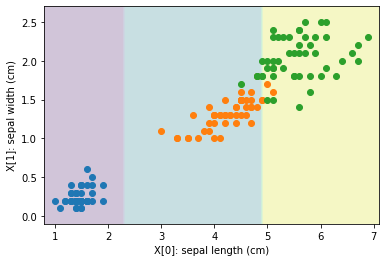

In [41]:
import matplotlib.pyplot as plt
import numpy as np

def plotDecisao(modelo, X, y):
    modelo.fit(X, y)

    x0s = np.linspace(np.min(X[:, 0])-0.2, np.max(X[:, 0])+0.2, 100)
    x1s = np.linspace(np.min(X[:, 1])-0.2, np.max(X[:, 1])+0.2, 100)

    x0, x1 = np.meshgrid(x0s, x1s)
    Xdec = np.c_[x0.ravel(), x1.ravel()]
    ypred = modelo.predict(Xdec)
    plt.contourf(x0, x1,ypred.reshape(x0.shape), alpha=0.25)
    for k in set(y):
        plt.plot(X[:, 0][y==k], X[:, 1][y==k], 'o', label=f"{iris.target_names[k]}[{k}]")
    plt.xlabel(f"X[0]: {iris.feature_names[0]}")
    plt.ylabel(f"X[1]: {iris.feature_names[1]}")
    plt.show()

plotDecisao(Arvore(), X, y)

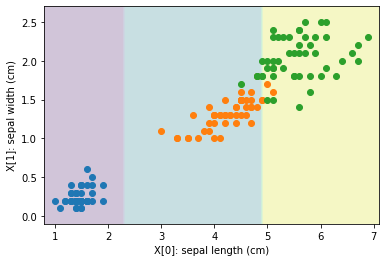

In [42]:
def impurezaValor(x, y, valor):
    maiores = x>valor
    impurezaMaiores = impureza(y[maiores])
    propMaiores = sum(maiores)/len(y)

    impurezaMenores = impureza(y[~maiores])
    propMenores = sum(~maiores)/len(y)
    impurezaTotal =  propMaiores*impurezaMaiores + propMenores*impurezaMenores

    return impurezaTotal, impurezaMaiores, impurezaMenores

impurezaValor(X[:, 0], y, 2)

plotDecisao(Arvore(), X, y)


    

In [43]:
def melhorValor(x, y):
    result = None
    menorImpureza = float('inf')
    xmax = np.max(x)
    xmin = np.min(x)

    while True:
        valor = (xmax-xmin)/2
        impTotal, impMaiores, impMenores  = impurezaValor(x, y, valor)
        if impTotal < menorImpureza:
            menorImpureza = impTotal
            result = valor
            if impMaiores == 0 or impMenores ==0:
                break
            if impMaiores < impMenores:
                xmin = valor
            else:
                xmax = valor
        else:
            break
    return result, menorImpureza

melhorValor(X[:, 0], y)
       




(2.95, 0.3333333333333333)

In [44]:
def melhorCaracteristica(X, y):
    impurezas = []
    valores = []
    for caracteristica in range(X.shape[1]):
        valor, impureza = melhorValor(X[:, caracteristica],y)
        impurezas.append(impureza)
        valores.append(valor)
    impurezas = np.array(impurezas)
    caracteristica = np.argmin(impurezas)
    return caracteristica, valores[caracteristica], impurezas[caracteristica]

print(melhorCaracteristica(X, y))


(0, 2.95, 0.3333333333333333)


In [45]:
class Arvore(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        self.caracteristica, self.valor, self.imp = melhorCaracteristica(X, y)
        self.valor = np.mean(X[:, self.caracteristica])
        maiores = X[:, self.caracteristica] > self.valor 
        if sum(maiores)>0 and sum(~maiores)>0:
            self.maiores = Arvore()
            self.maiores.fit(X[maiores,:], y[maiores])
            self.menores = Arvore()
            self.menores.fit(X[~maiores,:], y[~maiores])
        else:
            self.resposta = maisFrequente(y)

    def predict(self, X):
        y = np.empty((X.shape[0]))
        if hasattr(self, 'resposta'):
            y[:] = self.resposta
        else: 
            maiores = X[:, self.caracteristica] > self.valor
            y[maiores] = self.maiores.predict(X[maiores, :])
            y[~maiores] = self.menores.predict(X[~maiores, :])
        return y

modelo = Arvore()
modelo.fit(X, y)
ypred = modelo.predict(X)
accuracy_score(y, ypred)

0.9533333333333334

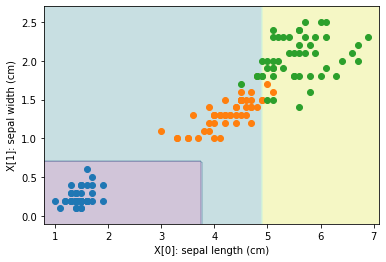

In [46]:
plotDecisao(Arvore(), X, y)

In [47]:
from sklearn.model_selection import cross_validate

scores = cross_validate(Arvore(),X, y)
scores['test_score'], np.mean(scores['test_score'])

(array([0.93333333, 0.93333333, 0.8       , 0.93333333, 1.        ]),
 0.9200000000000002)

In [52]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt

# monks-problems-2
dataset1 = fetch_openml(data_id='334')
X1, y1 = dataset1.data[:,:2], np.array(dataset1.target).astype(np.int)
plotDecisao(Arvore(method='gini'), X1, y1)

# blood-transfusion-service-center
dataset2 = fetch_openml(data_id='1464')
X2, y2 = dataset2.data[:,:2], np.array(dataset2.target).astype(np.int)

#  Engine1
dataset3 = fetch_openml(data_id='1560')
X3, y3 = dataset3.data[:,:2], np.array(dataset3.target).astype(np.int)
plotDecisao(Arvore(), X3, y3)

scores = cross_validate(Arvore(method='gini'),X1, y1)
mean_score = np.mean(scores['test_score'])
print(f"1 - score: {mean_score*100.0}%")

scores = cross_validate(Arvore(method='gini'),X2, y2)
mean_score = np.mean(scores['test_score'])
print(f"2 - score: {mean_score*100.0}%")

scores = cross_validate(Arvore(method='gini'),X3, y3)
mean_score = np.mean(scores['test_score'])
print(f"3 - score: {mean_score*100.0}%")

TypeError: object() takes no parameters